In [21]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Ellipse
import numpy as np
import astropy.units as u
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.coordinates import Distance
import pandas as pd
from pathlib import Path

In [22]:
path = Path("G28.37-ApogeeNet.txt")

# Keep only the ASCII-table lines that begin with '|'
with path.open() as f:
    lines = [ln for ln in f if ln.lstrip().startswith("|")]

# First '|' line is the header row; the rest are data rows
header = [c.strip() for c in lines[0].strip().strip("|").split("|")]
rows   = [[c.strip() for c in ln.strip().strip("|").split("|")] for ln in lines[1:]]

T = pd.DataFrame(rows, columns=header)

# Try to convert numeric-looking columns to numbers
for col in T.columns:
    T[col] = pd.to_numeric(T[col], errors="ignore")

# Make sure RA/Dec are numeric floats (column names are exactly 'ra' and 'dec' in your file)
T["ra"]  = pd.to_numeric(T["ra"],  errors="coerce")
T["dec"] = pd.to_numeric(T["dec"], errors="coerce")

# (Optional) drop rows missing coordinates
T = T.dropna(subset=["ra","dec"]).reset_index(drop=True)

print(T.shape, list(T.columns)[:25])  # quick sanity check


(167, 191) ['sdss_id', 'sdss4_apogee_id', 'gaia_dr2_source_id', 'gaia_dr3_source_id', 'tic_v8_id', 'healpix', 'lead', 'version_id', 'catalogid', 'catalogid21', 'catalogid25', 'catalogid31', 'n_associated', 'n_neighborhood', 'sdss5_target_flags', 'sdss4_apogee_target1_flags', 'sdss4_apogee_target2_flags', 'sdss4_apogee2_target1_flags', 'sdss4_apogee2_target2_flags', 'sdss4_apogee2_target3_flags', 'sdss4_apogee_member_flags', 'sdss4_apogee_extra_target_flags', 'ra', 'dec', 'l']


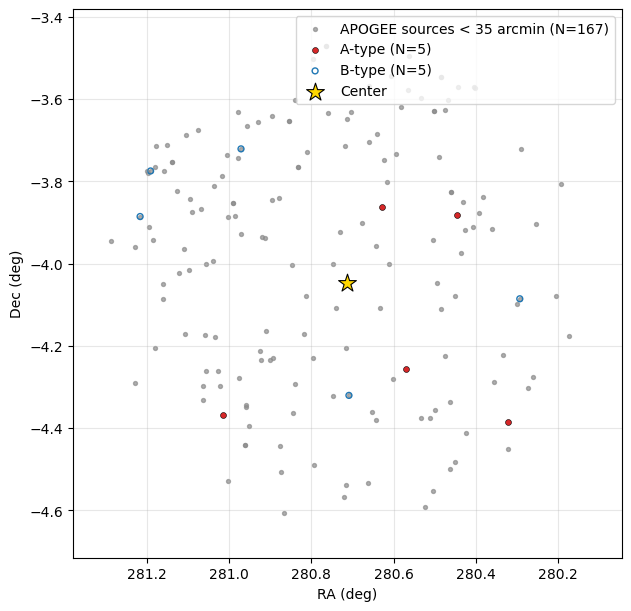

In [23]:
# center + radius
center = SkyCoord(280.7125*u.deg, -4.0483*u.deg, frame="icrs")  # 18:42:51, -04:02:54
radius = 40 * u.arcmin

# select from T
try:
    XY = T[['ra','dec']].copy()
except NameError:
    coords = SkyCoord(T['ra'].to_numpy()*u.deg, T['dec'].to_numpy()*u.deg)
    XY = T.loc[(center.separation(coords) <= radius).value, ['ra','dec']].copy()

fig, ax = plt.subplots(figsize=(6.4, 6.4))

# background points
nAPOGEE = len(XY)
ax.scatter(XY['ra'], XY['dec'], s=8, c='0.55', alpha=0.7,
           label=f'APOGEE sources < 35 arcmin (N={nAPOGEE})')


# OPTIONAL overlays
if {'parallax','parallax_error'}.issubset(T.columns):
    sn5 = (T.loc[XY.index, 'parallax'].abs() /
           T.loc[XY.index, 'parallax_error'].replace(0, np.nan)) >= 5
    nGaia = sn5.sum()
    ax.scatter(XY.loc[sn5,'ra'], XY.loc[sn5,'dec'], s=10, c='0.3', alpha=0.9,
               label=f'Gaia ϖ/σϖ ≥ 5 (N={nGaia})')

if {'teff','logg'}.issubset(T.columns):
    teff = T.loc[XY.index, 'teff']; logg = T.loc[XY.index, 'logg']
    A = teff.between(7500, 10000, inclusive='both') & (logg >= 3.5)
    B = (teff > 10000) & (teff <= 30000) & (logg >= 3.5)
    nA, nB = A.sum(), B.sum()
    ax.scatter(XY.loc[A,'ra'], XY.loc[A,'dec'], s=18, c='tab:red', edgecolor='k', lw=0.4,
               label=f'A-type (N={nA})')
    ax.scatter(XY.loc[B,'ra'], XY.loc[B,'dec'], s=18, facecolors='none', edgecolors='tab:blue', lw=1.0,
               label=f'B-type (N={nB})')
    
# center star + rings
ax.scatter(center.ra.deg, center.dec.deg, marker='*', s=180, c='gold', edgecolor='black', lw=0.8,
           label='Center')

# frame & cosmetics
pad = (radius.to(u.deg)).value
ax.set_xlim(center.ra.deg + pad, center.ra.deg - pad)  # flip RA like sky plots
ax.set_ylim(center.dec.deg - pad, center.dec.deg + pad)
ax.set_aspect('equal', 'box'); ax.grid(True, alpha=0.3)
ax.set_xlabel('RA (deg)'); ax.set_ylabel('Dec (deg)')
ax.legend(loc='upper right', frameon=True)
plt.tight_layout()
plt.show()
# plt.savefig('g28_scatter.png', dpi=300, bbox_inches='tight')
    